# Sample code for evaluation of anipose calibrations

In [58]:
from b06_source.camera_calibration import CalibrationForAnipose3DTracking, SingleCamDataForAnipose, TestPositionsGroundTruth

from pathlib import Path
import matplotlib.pyplot as plt
from b06_source.load_config import read_config

# for creating an interactive 3D plot
#%matplotlib widget

In [59]:
# define function that loops on calibration files
import os
import pandas as pd
import numpy as np
from itertools import cycle 


In [60]:
dummy_filepath = Path('random.mp4')
charuco_folder = Path('./test_data/Charuco_220825/')
intrinsic_calibrations_dir = Path('test_data/intrinsic_calibrations/')

In [61]:
test_data_dir = Path('test_data/evaluate_calibration/calibration_02/')

In [62]:
config = read_config("config.yaml")

### To switch between different calibrations, use one of the following paths:
- `'test_data/evaluate_calibration/calibration_00/'`
- `'test_data/evaluate_calibration/calibration_01/'`
- `'test_data/evaluate_calibration/calibration_02/'`

## Create individual camera objects with intrinsic calibrations & 2D coordinates of detected markers

In [63]:
top_cam = SingleCamDataForAnipose(cam_id = 'Top', filepath_synchronized_calibration_video = charuco_folder.joinpath('Top_cam_synchronized_for_calibration_all_parts.mp4'))
top_cam.load_test_position_markers_df_from_dlc_prediction(filepath_deeplabcut_prediction = test_data_dir.joinpath('Top_manual_test_position_marker_fake.h5'))
top_cam.load_intrinsic_camera_calibration(filepath_intrinsic_calibration = intrinsic_calibrations_dir.joinpath('Top_checkerboard_intrinsic_calibration_results.p'))

bottom_cam = SingleCamDataForAnipose(cam_id = 'Bottom', filepath_synchronized_calibration_video = charuco_folder.joinpath('Bottom_cam_synchronized_for_calibration_all_parts.mp4'))
bottom_cam.load_test_position_markers_df_from_dlc_prediction(filepath_deeplabcut_prediction = test_data_dir.joinpath('Bottom_manual_test_position_marker_fake.h5'))
bottom_cam.load_intrinsic_camera_calibration(filepath_intrinsic_calibration = intrinsic_calibrations_dir.joinpath('Bottom_checkerboard_intrinsic_calibration_results.p'))

side1_cam = SingleCamDataForAnipose(cam_id = 'Side1', filepath_synchronized_calibration_video = charuco_folder.joinpath('Side1_cam_synchronized_for_calibration_all_parts.mp4'))
side1_cam.load_test_position_markers_df_from_dlc_prediction(filepath_deeplabcut_prediction = test_data_dir.joinpath('Side1_manual_test_position_marker_fake.h5'))
side1_cam.load_intrinsic_camera_calibration(filepath_intrinsic_calibration = intrinsic_calibrations_dir.joinpath('Side1_checkerboard_intrinsic_calibration_results.p'))

side2_cam = SingleCamDataForAnipose(cam_id = 'Side2', filepath_synchronized_calibration_video = charuco_folder.joinpath('Side2_cam_synchronized_for_calibration_all_parts.mp4'))
side2_cam.load_test_position_markers_df_from_dlc_prediction(filepath_deeplabcut_prediction = test_data_dir.joinpath('Side2_manual_test_position_marker_fake.h5'))
side2_cam.load_intrinsic_camera_calibration(filepath_intrinsic_calibration = intrinsic_calibrations_dir.joinpath('Side2_checkerboard_intrinsic_calibration_results.p'))

ground1_cam = SingleCamDataForAnipose(cam_id = 'Ground1', filepath_synchronized_calibration_video = charuco_folder.joinpath('Ground1_cam_synchronized_for_calibration_all_parts.mp4'))
ground1_cam.load_test_position_markers_df_from_dlc_prediction(filepath_deeplabcut_prediction = test_data_dir.joinpath('Ground1_manual_test_position_marker_fake.h5'))
ground1_cam.load_intrinsic_camera_calibration(filepath_intrinsic_calibration = intrinsic_calibrations_dir.joinpath('Ground1_checkerboard_intrinsic_calibration_results.p'))

ground2_cam = SingleCamDataForAnipose(cam_id = 'Ground2', filepath_synchronized_calibration_video = charuco_folder.joinpath('Ground2_cam_synchronized_for_calibration_all_parts.mp4'))
ground2_cam.load_test_position_markers_df_from_dlc_prediction(filepath_deeplabcut_prediction = test_data_dir.joinpath('Ground2_manual_test_position_marker_fake.h5'))
ground2_cam.load_intrinsic_camera_calibration(filepath_intrinsic_calibration = intrinsic_calibrations_dir.joinpath('Ground2_checkerboard_intrinsic_calibration_results.p'))

single_cams = [bottom_cam, ground1_cam, ground2_cam, side1_cam, side2_cam, top_cam]
#single_cams = [ground1_cam, ground2_cam, side1_cam, side2_cam, top_cam]

User info: since no other information were provided, "cropping_offsets" were set to the corresponding default values: (0, 0).
User info: since no other information were provided, "flipped_horizontally" & "flipped_vertically" were set to the corresponding default values: False.
User info: since no other information were provided, "degrees_rotated_clockwise" were set to the corresponding default values: 0.
User info: since no other information were provided, "cropping_offsets" were set to the corresponding default values: (0, 0).
User info: since no other information were provided, "flipped_horizontally" & "flipped_vertically" were set to the corresponding default values: False.
User info: since no other information were provided, "degrees_rotated_clockwise" were set to the corresponding default values: 0.
User info: since no other information were provided, "cropping_offsets" were set to the corresponding default values: (0, 0).
User info: since no other information were provided, "flip

## Load calibration, triangulate markers & plot

In [64]:
PATH_TO_CAL = './test_data/evaluate_calibration/calibration_0'
CAL_FILE = "/anipose_calibration_all_cams.toml"

AttributeError: 'CalibrationForAnipose3DTracking' object has no attribute 'anipose_io'

In [86]:
def finding_optimal_calibration(single_cams,config, path_to_cal, cal_file, max_iters):
    
    calibration_distances = pd.DataFrame(columns=None, index=None)
    calibration_percentages = pd.DataFrame(columns=None, index=None)
    
    ##### INITIALIZE CALIBRATION #######
    calibrations_counter = 0
    error = 1
    while error>0.1:
        if calibrations_counter < max_iters:
            calibration_n = str(calibrations_counter)
            anipose_calibration = CalibrationForAnipose3DTracking(single_cams_to_calibrate = single_cams)
            anipose_calibration.load_calibration(filepath = path_to_cal + calibration_n + cal_file)
            anipose_calibration.evaluate_triangulation_of_test_position_markers(config)
            calibration_errors = anipose_calibration.anipose_io['distance_errors_in_cm']
            calibration_angles_errors = anipose_calibration.anipose_io['angles_error_screws_plan']
            for reference in calibration_errors.keys():
                all_percentage_errors = [percentage_error for marker_id_a, marker_id_b, distance_error, percentage_error in calibration_errors[reference]['individual_errors']]
                
            #    all_angle_percentage_errors = [percentage_error for marker_id_a, marker_id_b, distance_error, percentage_error in calibration_angles_errors[reference]['individual_errors']]
            
            mean_dist_err_percentage = np.asarray(all_percentage_errors).mean()
            #mean_angle_err_percentage = np.asarray(all_angle_percentage_errors).mean()
            #error = (mean_percentage + mean_angle_err_percentage)/2
            
            error = mean_dist_err_percentage
            
        else:
            raise ValueError("Couldn't converge")
        
        calibrations_counter+=1
        
        print("Calibration # "+ str(calibrations_counter)+
              "\n mean percentage error: "+ str(mean_dist_err_percentage))
    print("Good Calibration reached: \n" +
         "Calibration # "+ str(calibrations_counter)+
              "\n mean percentage error: "+ str(mean_dist_err_percentage))


100%|███████████████████████████████| 15/15 [00:00<00:00, 2165.44it/s]


Mean reprojection error: 383.2729930707433
Using screw1_bottom_screw2_bottom as reference distance, the mean distance error is: 8.460095248525732 cm.
Using screw1_bottom_screw1_top as reference distance, the mean distance error is: 7.599210825354147 cm.
Using screw1_bottom_screw1_nut as reference distance, the mean distance error is: 7.215749009089928 cm.
Using screw1_bottom_screw3_bottom as reference distance, the mean distance error is: 7.766928010655272 cm.
Using screw1_bottom_screw4_bottom as reference distance, the mean distance error is: 11.125117872820018 cm.
Using screw2_bottom_screw3_bottom as reference distance, the mean distance error is: 6.546539615294331 cm.
Using screw2_bottom_screw4_bottom as reference distance, the mean distance error is: 9.029071972927959 cm.
Using screw1_top_screw1_bottom as reference distance, the mean distance error is: 7.599210825354147 cm.
Using screw1_top_screw1_nut as reference distance, the mean distance error is: 9.482618771957604 cm.
Using sc

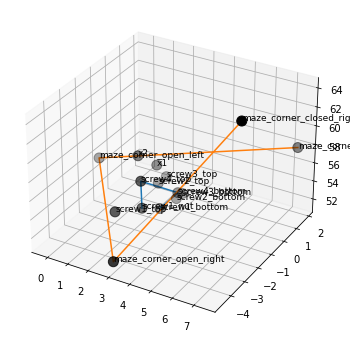

Calibration # 1
 mean percentage error: 1.0003761153699682


100%|███████████████████████████████| 15/15 [00:00<00:00, 1556.02it/s]


Mean reprojection error: 11.894037836419232
Using screw1_bottom_screw2_bottom as reference distance, the mean distance error is: 0.8897392601690918 cm.
Using screw1_bottom_screw1_top as reference distance, the mean distance error is: 0.642083794535831 cm.
Using screw1_bottom_screw1_nut as reference distance, the mean distance error is: 0.743133124702456 cm.
Using screw1_bottom_screw3_bottom as reference distance, the mean distance error is: 0.5144662369594786 cm.
Using screw1_bottom_screw4_bottom as reference distance, the mean distance error is: 0.7702582210842549 cm.
Using screw2_bottom_screw3_bottom as reference distance, the mean distance error is: 0.9137251288953466 cm.
Using screw2_bottom_screw4_bottom as reference distance, the mean distance error is: 1.5480746186624548 cm.
Using screw1_top_screw1_bottom as reference distance, the mean distance error is: 0.642083794535831 cm.
Using screw1_top_screw1_nut as reference distance, the mean distance error is: 2.3700111659161145 cm.
Us

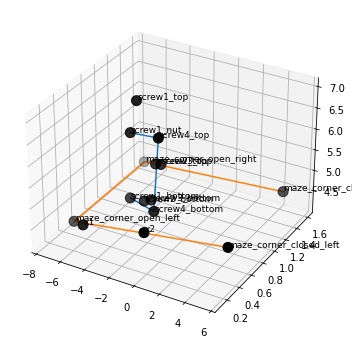

Calibration # 2
 mean percentage error: 0.07575337844305553
Good Calibration reached: 
Calibration # 2
 mean percentage error: 0.07575337844305553


In [87]:
finding_optimal_calibration(single_cams,config, PATH_TO_CAL, CAL_FILE, max_iters=3)